# ECML-PKDD 2024 - SMAC: Seismic Monitoring and Analysis Challenge
> **Author**: Pascal Tribel - <pascal.tribel@ulb.be> - Machine Learning Group - ULB
> 
> **Supervision**: Gianluca Bontempi - <gianluca.bontempi@ulb.be> - Machine Learning Group - ULB

## Imports

In [1]:
from hashlib import sha256
import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.ensemble
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
import seaborn as sns
import torch
from tqdm.auto import tqdm
from torchgeo.datasets import QuakeSet

## Introduction
In the occasion of ECML-PKDD 2024, the Seismic Monitoring and Analysis Challenge has been proposed. In this competition, it is asked to classify a set of sattelite images depending on whether or not the area they represent has been hit by an earthquake, and, if so, to determine the magnitude of this earthquake. The sattelite data is obtained by SENTINEL-1 technique (which work like a radar), emitting vertically polarized signal and receiveing the vertically and horizontally polarized reflection. Those two reflections give different information about the structure and shape of the target area. More specifically, their evolution in time give information about the ground deformation.
### Provided data
Three datasets are provided for the competition, implemented in the [TorchGeo](https://github.com/microsoft/torchgeo/tree/main) _QuakeSet_ class:
- Training set: 2266 samples: 1319 affected and 947 unaffected (`train_set`)
- Validation set: 550 samples: 309 affected and 241 unaffected (`val_set`)
- Testing set: 511 samples: 278 affected and 233 unaffected (`test_set`)

The ratios in the different datasets are:

|Dataset|% of affected areas|% of unaffected areas|#affected/#unaffected|
|-|-|-|-|
|Training|58.2%|41.8%|1.393|
|Validation|56.2%|43.8%|1.282|
|Testing|54.4%|45.5%|1.193|

In [2]:
train_set = QuakeSet(root="../data", split="train")
val_set = QuakeSet(root="../data", split="val")
test_set_may = QuakeSet(root="../data", split="test")
test_set = QuakeSet(root="../private_set", split="test")

Each item in those datasets is a set of four images, a label (affected/unaffected, `0/1`) and an earthquake magnitude (if the area is affected `4<10`). The four images are Sentinel-1 images (polarized _vertical emission - vertical reflection_ $VV$ and _vertical emission - horizontal reflection_ $VH$) taken respectively at most 13 days before ($VV_{t_0}$ and $VH_{t_0}$) and 13 days after ($VV_{t_1}$ and $VH_{t_1}$) a possible earthquake event. Each of those images represent a $20*20 km^2$ area, with a resolution of $512*512$ pixels. A pixel has therefore a coverage of $39*39 m^2$.

The time interval between the two timesteps is not provided.

Here is an example of item (the first of the training set):

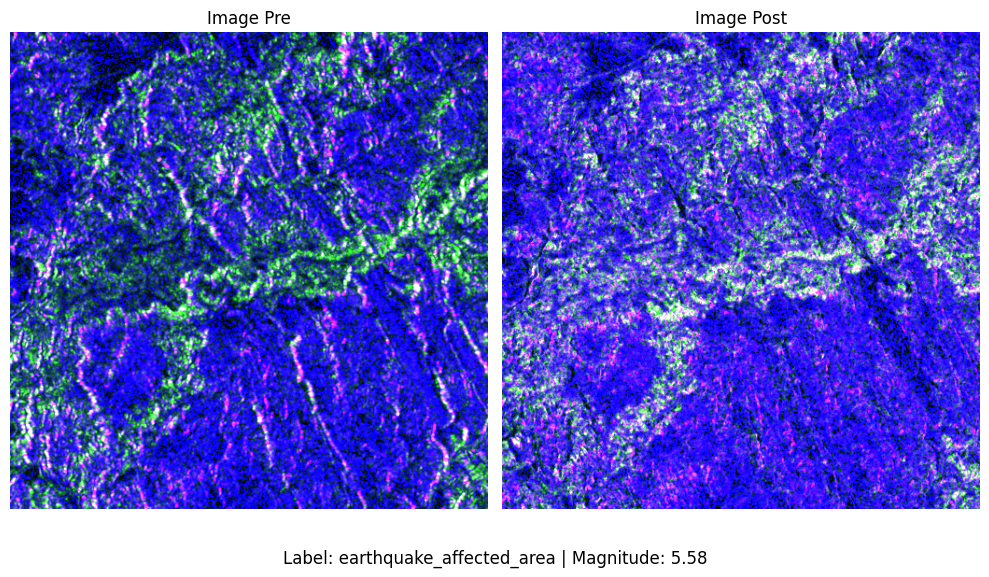

In [3]:
train_set.plot(train_set[0])

The earthquakes in the three datasets are related to events for which the epicenter is distributed across the world:

![title](geographic_distribution.png)

### Tasks
The competition consists of two tasks: 
- Classification of the images: affected or unaffected
- Regression of the event magnitude
### Scalability
In order to assess the scalability of the pipeline, it is required to compute the number of _floating point operations_ (FLOP) of the whole program, including the data pre- and post-processing. Unfortunately, _python-papi_ runs neither on our MacOS laptop nor on our lab GPU server. Therefore we propose a complete computation of this quantity, based on the definition given in [the chapter 
"In More Depth: MFLOPS as a Performance Metric"](https://course.ccs.neu.edu/cs3650/ssl/TEXT-CD/Content/COD3e/InMoreDepth/IMD4-MFLOPS-as-a-Performance-Metric.pdf). This definition states:

> A floating-point operation is an addition, subtraction, multiplication, or division operation applied to a number in a single or double precision floating- point representation.

More importantly, this does not consider comparison nor data access as FLOPs.

## Feature extraction
Our solution implies two different kind of features:
- Quantile-based features
- Zero-differences

### Quantile-based features
Quantiles computation only requires comparisons and data access. This is a leightweight operation computed on two levels:
- On the four images composing an item
- On the respective differences between $VV_{t_0}$ and $VV_{t_1}$, and between $VH_{t_0}$ and $VH_{t_1}$
  
We compute every quantile of 2% from 0% up to 98% included. This leads to a total of 300 features.

### Zero differences
At the scale of the provided samples ($1$ pixel covers $39*39m^2$), changes have to be important enough to imply a difference in the sattelite imagery. Two areas unaffected by such big change should present no difference between the two timesteps. So, the difference between timesteps images can bring information, especially when this difference is null.

Although, there may be some noise present on the different images. Our way to process this noise can be explained by looking at the histogram shapes of the two item classes.
We show the shape of the histogram of the difference between $VV$ images, and of the difference between $VH$ images. 

If the area is affected:

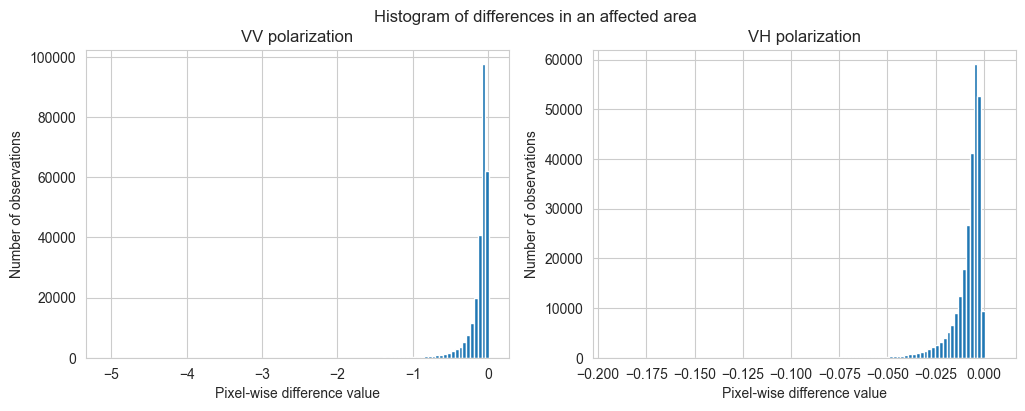

In [4]:
sns.set_style("whitegrid")
affected_example = torch.flatten(train_set[0]["image"], start_dim=1).numpy()
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Histogram of differences in an affected area")
ax[0].hist(affected_example[2]-affected_example[0], bins=100)
ax[0].set_xlabel("Pixel-wise difference value")
ax[0].set_ylabel("Number of observations")
ax[0].set_title("VV polarization")
ax[1].hist(affected_example[3]-affected_example[1], bins=100)
ax[1].set_xlabel("Pixel-wise difference value")
ax[1].set_ylabel("Number of observations")
ax[1].set_title("VH polarization")
plt.savefig("affected.jpg", dpi=150)
plt.show()

compared to the case of an unaffected area:

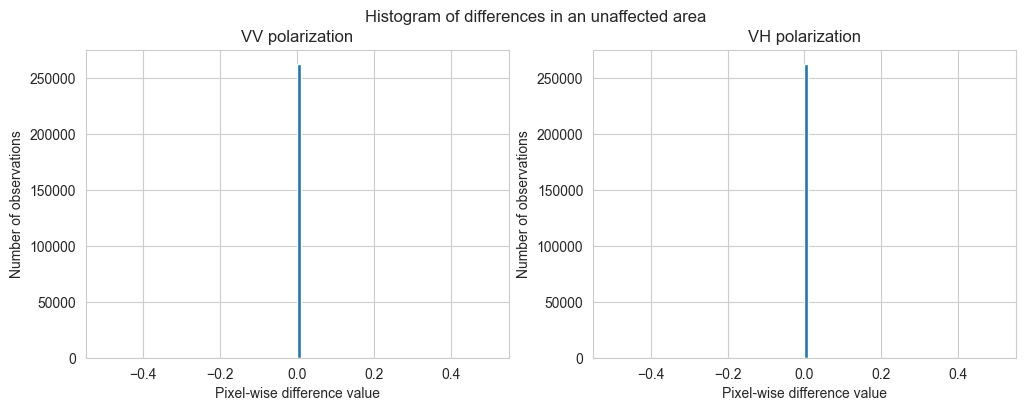

In [5]:
affected_example = torch.flatten(train_set[1]["image"], start_dim=1).numpy()
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Histogram of differences in an unaffected area")
ax[0].hist(affected_example[2]-affected_example[0], bins=100)
ax[0].set_xlabel("Pixel-wise difference value")
ax[0].set_ylabel("Number of observations")
ax[0].set_title("VV polarization")
ax[1].hist(affected_example[3]-affected_example[1], bins=100)
ax[1].set_xlabel("Pixel-wise difference value")
ax[1].set_ylabel("Number of observations")
ax[1].set_title("VH polarization")
plt.savefig("unaffected.jpg", dpi=150)
plt.show()

In the case of a normally-randomly noised image, the differences will be normally distributed around $0$. We decide to manually threshold the differences to $0.75$ in absolute value for $VV$ images and to $0.05$ for $VH$ images. This leads to the following feature extraction function:

In [6]:
r = np.arange(0.0, 1, 0.02)
def create_features_vector(images):
    """
    Creates a feature vector from the input image (4, 512, 512).
    This vector is made of:
        - 50 pixel quantiles (*2%) on the 4 channels
        - 50 pixel quantiles (*2%) on the 2 differences between VV and VH channels
    resulting in 300 features.
    """
    images = torch.flatten(images, start_dim=1).numpy().astype(np.float32)
    images_difference_VH = np.clip(images[3] - images[1], -0.05, 0.05)
    images_difference_VV = np.clip(images[2] - images[0], -0.75, 0.75)
    vector = np.concatenate(np.apply_along_axis(lambda x: np.quantile(x, r), 1, images), axis=0)
    vector = np.append(vector, [np.quantile(images_difference_VH, r), np.quantile(images_difference_VV, r)])
    return vector

We can compute the number of FLOP needed by this function:
- The flatten operation requires 0 FLOP
- The two differences between channels require each $512*512$ operations: $2*512*512$
- The threshold operations require 0 FLOP
- The quantile operations require 0 FLOP

Therefore, for one unique image, this preprocessing step takes a total of $2*512*512$ FLOPs.

We notice also that the images of an unaffected area before and after a (non-) event should be null. Therefore, if one of the two channels difference is all-zero, then the image can be directly labelled as _unaffected_ and its magnitude can be set to zero. Checking this for one image requires $2*512*512$ FLOPs (for the differences).

In [7]:
def get_zero_differences_indices(dataset):
    """
    Returns the indices of the items in the dataset passed as parameter for which at least one of the VV or VH channels
    difference is all-zero.
    """
    zero_differences_indices = []
    for i in tqdm(range(len(dataset))):
        image = dataset[i]["image"].numpy()
        if not np.any(image[3]-image[1]) or not np.any(image[2]-image[0]):
            zero_differences_indices.append(i)
    return zero_differences_indices

### Feature extraction and preprocessing

In [8]:
GENERATING = True
if GENERATING:
    train_features = []
    train_labels = []
    train_magnitudes = []
    val_features = []
    val_labels = []
    val_magnitudes = []
    
    for i in tqdm(range(len(train_set))):
        image = train_set[i]["image"]
        train_features.append(create_features_vector(image))
        train_labels.append(train_set[i]["label"].item())
        train_magnitudes.append(train_set[i]["magnitude"].item())
    
    for i in tqdm(range(len(val_set))):
        image = val_set[i]["image"]
        val_features.append(create_features_vector(image))
        val_labels.append(val_set[i]["label"].item())
        val_magnitudes.append(val_set[i]["magnitude"].item())
    train = pd.DataFrame(np.array(train_features, dtype=np.float32))
    val = pd.DataFrame(np.array(val_features, dtype=np.float32))
else:
    train = pd.read_csv("train.csv", index_col=False)
    val = pd.read_csv("val.csv", index_col=False)

  0%|          | 0/2266 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

In [9]:
train = pd.DataFrame(np.array(train_features, dtype=np.float32))
val = pd.DataFrame(np.array(val_features, dtype=np.float32))

The normalization step is done with the mean and the standard deviation of the training set features. Each feature has to be normalized, so this implies $300*2$ FLOPs:

In [10]:
m = train.mean()
s = train.std()

train = (train-m)/s
val = (val-m)/s

train["label"] = np.array(train_labels, dtype=np.float32)
train["magnitude"] = np.array(train_magnitudes, dtype=np.float32)

val["label"] = np.array(val_labels, dtype=np.float32)
val["magnitude"] = np.array(val_magnitudes, dtype=np.float32)

train.columns = train.columns.astype(str)
val.columns = val.columns.astype(str)

In [50]:
np.save("means.npy", m)
np.save("std.npy", s)

And we retrieve the indices of items having at least one of the two differences (in $VV$ or $VH$) that is all-zero:

In [11]:
train_zero_differences_indices = get_zero_differences_indices(train_set)
val_zero_differences_indices = get_zero_differences_indices(val_set)

  0%|          | 0/2266 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

## Modelling
The task is decomposed in three steps:
1. A first estimation of the item class is computed
2. This first estimation is used to make the magnitude regression
3. The magnitude value is used to compute the final class

This last step ensures that the regressed magnitude and the associated class is coherent (as suggested in the provided `starter-kit`).
### Class estimation
We propose to use the [lightgbm](https://lightgbm.readthedocs.io/en/stable/)'s `LGBMClassifier` in order to classify the different events. We predict as _unaffected_ the ones having on channel difference being all-zeros. Those are excluded from the training set, because we already have a method for classifying them. `GradientBoosting` are based on decision trees, which are made of comparisons. The number of FLOP required by the inference step is then $0$.

We discard the 1830$^{th}$ element of the training set (being an outlier, see appendix).

In [12]:
outlier = [1830]
train_drop = train_zero_differences_indices + outlier 

In [13]:
len(train_drop)

710

In [14]:
classifier = lightgbm.LGBMClassifier(verbose=-1, random_state=42).fit(
    train.drop(["label", "magnitude"], axis=1).drop(train_drop, axis=0), 
    train["label"].drop(train_drop, axis=0))
val_classifications = classifier.predict(val.drop(["label", "magnitude"], axis=1)).astype(np.int8)
val_classifications[val_zero_differences_indices] = 0

In [37]:
classifier.booster_.save_model('classifier.txt')

The validation leads to this confusion matrix:

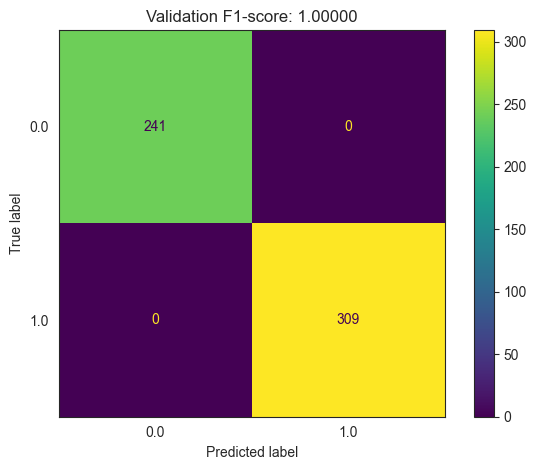

In [15]:
sns.set_style("white")
ConfusionMatrixDisplay.from_predictions(val["label"], np.round(val_classifications))
plt.title(f"Validation F1-score: %.5f"%f1_score(val["label"], np.round(val_classifications)))
plt.tight_layout()
plt.savefig("val_confusion.jpg", dpi=150)
plt.show()

### Regression
The class predicted by the classifier can be used as an extra feature in order to determine the eventual magnitude:

In [16]:
train_regression_set = train.copy()
val_regression_set = val.copy()
val_regression_set["label"] = classifier.predict(val.drop(["magnitude", "label"], axis=1))

Then, we use an instance of `LGBMRegressor`, a `GradientBoosting` method (FLOPs = $0$), and we replace the magnitude of the samples having an all-zero channel difference with $0$.

We exclude from the training set half of the unaffected samples, since their magnitude is $0$, in order to raise the attention given by the regressors to the affected samples.

In [17]:
unaffected = train_regression_set[train_regression_set["magnitude"]==0].index
unaffected = unaffected[:len(unaffected)//2]

regressor = lightgbm.LGBMRegressor(verbose=-1, random_state=42).fit(
    train_regression_set.drop(["magnitude"], axis=1).drop(unaffected, axis=0), 
    train_regression_set["magnitude"].drop(unaffected, axis=0)
)

In [38]:
regressor.booster_.save_model('regressor.txt')

In [18]:
val_regression = regressor.predict(val_regression_set.drop(["magnitude"], axis=1))
val_regression[val_zero_differences_indices] = 0

We apply a threshold on the produced regressed values:
- Maximal magnitude: 10
- Minimal magnitude: 4

In [19]:
len(val_zero_differences_indices)

152

In [20]:
val_regression[val_regression < 4] = 0
val_regression[val_regression > 10] = 10

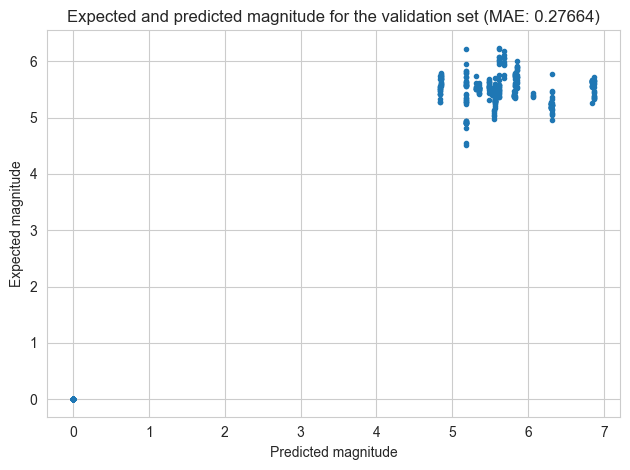

In [21]:
sns.set_style("whitegrid")
plt.scatter(val["magnitude"], val_regression, marker='.')
plt.xlabel("Predicted magnitude")
plt.ylabel("Expected magnitude")
plt.title(f"Expected and predicted magnitude for the validation set (MAE: %.5f)"%np.mean(np.abs(val_regression_set["magnitude"]-\
                                                                                                val_regression)))
plt.tight_layout()
plt.savefig("Val_regression.jpg", dpi=150)
plt.show()

We use the regression value to compute the final classes:

In [22]:
print("Validation F1-Score:", f1_score(val["label"], (val_regression>0).astype(np.int8)))

Validation F1-Score: 1.0


## Submission process
Finally, we follow the process of submission generation proposed in the competition `starter-kit`.

In [23]:
def generate_submission_file(dataset, predicted_regression, flops, filename="submission.csv"):
    """
    Generates a submission file based on the prediction for the given parameters.
    """
    predictions = []
    for i in range(len(dataset)):
        metadata = dataset.data[i]
        key = metadata['key']
        predictions += [
            {"key": key, "magnitude": predicted_regression[i], "affected": int(predicted_regression[i]>0), "flops": flops}
        ]
    pd.DataFrame(predictions).to_csv(filename, index=False)

generate_submission_file(val_set, val_regression, 4*512*512+600, "submission_validation.csv")

## Total number of FLOP
The only FLOP that are computed in the presented pipeline are the differences used in the preprocessing step and the features normalization. The total number of FLOP needed for the inference of one sample is then: $4*512*512 + 600 = 1049176$. This result is coherent with the SVC and RFC FLOPs quantity proposed for the classification task in [the QuakeSet presentation article](https://arxiv.org/abs/2403.18116).

## Testing and submission generation
### Preprocessing

In [51]:
m = np.load("means.npy")
s = np.load("std.npy")

In [24]:
test_features = []
test_labels = []
test_magnitudes = []
for i in tqdm(range(len(test_set))):
    image = test_set[i]["image"]
    test_features.append(create_features_vector(image))
    test_labels.append(test_set[i]["label"].item())
    test_magnitudes.append(test_set[i]["magnitude"].item())

  0%|          | 0/300 [00:00<?, ?it/s]

In [25]:
test = pd.DataFrame(np.array(test_features, dtype=np.float32))
test = (test-m)/s
test["label"] = np.array(test_labels, dtype=np.float32)
test["magnitude"] = np.array(test_magnitudes, dtype=np.float32)
test.columns = test.columns.astype(str)

In [26]:
test.shape

(300, 302)

### Model Loading

In [39]:
classifier = lightgbm.Booster(model_file='classifier.txt')
regressor = lightgbm.Booster(model_file='regressor.txt')

### Inference
We predict the class of the test samples:

In [27]:
test_zero_differences_indices = get_zero_differences_indices(test_set)

  0%|          | 0/300 [00:00<?, ?it/s]

In [28]:
len(test_zero_differences_indices)

113

In [40]:
test_classifications = classifier.predict(test.drop(["label", "magnitude"], axis=1)).astype(np.int8)
test_classifications[test_zero_differences_indices] = 0

And we perform the regression inference:

In [41]:
test_regression_set = test.copy()
test_regression_set["label"] = test_classifications
test_regression = regressor.predict(test.drop(["magnitude"], axis=1))
test_regression[test_zero_differences_indices] = 0
test_regression[test_regression < 4] = 0
test_regression[test_regression > 10] = 10

We use the regressed values to compute the final classes:

In [42]:
classes = (test_regression>0).astype(np.int8)

We generate the submission file:

In [43]:
flops = 4*512*512+600

In [44]:
generate_submission_file(test_set, test_regression, 4*512*512+600, "submission.csv")

In [45]:
pd.read_csv("submission.csv")

key  magnitude  affected  \
0    00326e2f2cff5dcc164582a963a7e42593672e7760b065...   5.120643         1   
1    01aa5fe774c80e2d51ca814372f79dcc54248d1b3df721...   0.000000         0   
2    01f7f46706bb5b948de7b3eccb800bd401a3221ed253ee...   5.509089         1   
3    038dd9c74fcfe8bcf5a4b339d215a95c9d22da63959b31...   0.000000         0   
4    03a5654c865bcca11265fef8092f1f15c4ce1664d228d7...   4.621654         1   
..                                                 ...        ...       ...   
295  fddc020a55fd52f9421c9fa8e50fe0d633a404076e6635...   0.000000         0   
296  fe39a4c56f69e3e279e71d1e3ef7355cb2c297121ef31b...   0.000000         0   
297  fe7f03e92faf9d27f2a0b1e7e13f96cb1260c46f685858...   5.557283         1   
298  ff6a6f135d2f96f0c91c82dfb2a0645d95c557a5582f86...   5.881895         1   
299  ffd47214e49a0af1648350a770b9318b4fb070bb9fa303...   5.440185         1   

       flops  
0    1049176  
1    1049176  
2    1049176  
3    1049176  
4    1049176  
..       ...  
295  1049176  
296  1049176  
297  1049176  
298  1049176  
299  1049176  

[300 rows x 4 columns]

We explore the robustness of our pipeline in the Appendix.

## For further exploration
We save the different datasets used for further usage:

In [36]:
train_save = train.copy()
val_save = val.copy()
test_save = test.copy()
train_save["zero_diff"] = np.zeros(train_save.shape[0])
val_save["zero_diff"] = np.zeros(val_save.shape[0])
test_save["zero_diff"] = np.zeros(test_save.shape[0])

train_save.loc[train_zero_differences_indices, "zero_diff"] = 1
val_save.loc[val_zero_differences_indices, "zero_diff"] = 1
test_save.loc[test_zero_differences_indices, "zero_diff"] = 1

train_save.to_csv("train.csv", index=False)
val_save.to_csv("val.csv", index=False)
test_save.to_csv("test.csv", index=False)

## Sources:
- [Competition platform](https://www.codabench.org/competitions/2222/#/pages-tab)
- [QuakeSet](https://arxiv.org/abs/2403.18116)
- [FLOP definition](https://course.ccs.neu.edu/cs3650/ssl/TEXT-CD/Content/COD3e/InMoreDepth/IMD4-MFLOPS-as-a-Performance-Metric.pdf)